Question 4: Several countries have implemented a series of policies aimed at hindering the development of new energy electric vehicles in China. Establish a mathematical model to analyze the impact of these policies on the development of new energy electric vehicles in our country.

In [18]:
import pandas as pd
from statsmodels.graphics import tsaplots
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import numpy as np

In [19]:
export_data = pd.read_excel('./Chinese_export.xlsx')
export_data.head(15)

,Year,Finished Automobile,Electric Vehicle
0,2014,947900,21200
1,2015,754900,64200
2,2016,810000,70200
3,2017,1063800,106400
4,2018,1041000,10200
5,2019,1202000,37000
6,2020,995000,70000
7,2021,2015000,210000
8,2022,3111000,469000


In [20]:
def slot(start, end):
    slotted_df = export_data
    slotted_df['Year'] = pd.to_datetime(slotted_df['Year'], format='%Y')
    slotted_df = slotted_df[(slotted_df['Year'] >= start) & (slotted_df['Year'] <= end)]
    slotted_df.set_index('Year', inplace=True)
    return slotted_df

In [21]:
# input_automobile = slot('2014', '2018')
input_automobile = export_data
input_electric = input_automobile
input_automobile = pd.DataFrame(input_automobile['Finished Automobile'])
input_electric = pd.DataFrame(input_electric['Electric Vehicle'])

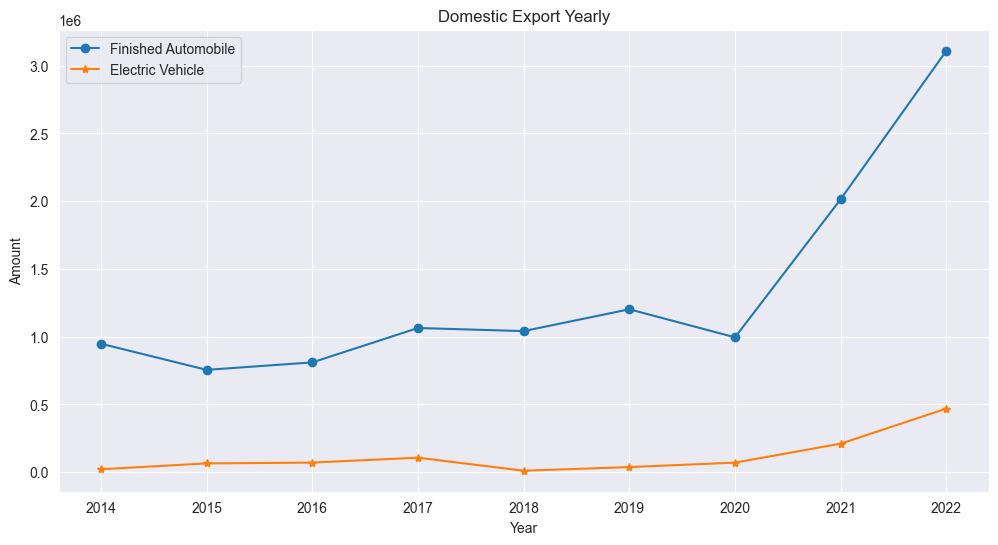

In [22]:
export_data.set_index(export_data['Year'], inplace=True)
plt.figure(figsize=(12, 6))
plt.plot(export_data['Finished Automobile'], label='Finished Automobile', marker='o')
plt.plot(export_data['Electric Vehicle'], label='Electric Vehicle', marker='*')
plt.xlabel('Year')
plt.ylabel('Amount')
plt.title('Domestic Export Yearly')
plt.legend()
plt.savefig('Domestic Export Yearly.png')
plt.show()

In [14]:
class my_arima:
    def __init__(self, df, name):
        self.input_df = df
        self.Name = name
        self.best_order = self.find_best_order()
        self.model = self.create_model()
        self.plot_summary()
        self.forcast = self.predict()

    def create_model(self):
        endog = self.input_df
        model = ARIMA(order=self.best_order, endog=endog)
        return model.fit()

    def predict(self):
        future_dates = pd.date_range(start="2017", end="2022", freq='Y')

        forecast = self.model.get_forecast(steps=len(future_dates))
        forecast_df = forecast.summary_frame()

        return forecast_df

    def find_best_order(self):
        df = self.input_df
        column_name = df.columns[0]
        p_values = range(0, 7)  # AR
        d_values = range(0, 3)  # Diff
        q_values = range(0, 7)  # MA
        param_combinations = [(p, d, q) for p in p_values for d in d_values for q in q_values]

        best_model = None
        best_aic = np.inf

        tscv = TimeSeriesSplit(n_splits=5)
        df = pd.DataFrame(df)
        for params in param_combinations:
            model = auto_arima(df[column_name], seasonal=False, suppress_warnings=True,
                               stepwise=True, order=(params[0], params[1], params[2]),
                               scoring='mse',  # Use mean squared error for model selection
                               cv=tscv)
            aic = model.aic()

            if aic < best_aic:
                best_model = model
                best_aic = aic

        print(column_name)
        print("Best Model Order (p, d, q):", best_model.order)
        print("Best AIC:", best_aic)
        return best_model.order

    def plot_summary(self):
        # Diagnostic plots
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))

        # ACF Plot
        tsaplots.plot_acf(self.model.resid, lags=4, ax=axes[0, 0])
        axes[0, 0].set_title('Autocorrelation Function (ACF)')

        # PACF Plot
        tsaplots.plot_pacf(self.model.resid, lags=1, ax=axes[0, 1])
        axes[0, 1].set_title('Partial Autocorrelation Function (PACF)')

        # Predicted values
        pred = self.model.get_prediction(start=1, end=len(self.input_df))
        pred_ci = pred.conf_int()

        # Plotting actual vs. predicted
        axes[1, 0].plot(self.input_df.index, self.input_df[self.input_df.columns[0]], label='Observed')
        axes[1, 0].plot(pred.predicted_mean.index, pred.predicted_mean, color='red', label='Predicted')
        axes[1, 0].fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=0.2)
        axes[1, 0].set_title('Actual vs. Predicted')
        axes[1, 0].legend()

        # Histogram of Residuals
        axes[1, 1].hist(self.model.resid, bins=20)
        axes[1, 1].set_title('Histogram of Residuals')

        plt.savefig(f'{self.Name}_Summary.png')
        plt.show()

In [ ]:
auto_mobile_model = my_arima(df=input_automobile, name='Automobile_export')

In [98]:
mobile_forcast_df = auto_mobile_model.forcast
mobile_forcast_df

Finished Automobile,mean,mean_se,mean_ci_lower,mean_ci_upper
2023-01-01,2.730383e+06,6.225518e+05,1.510204e+06,3.950562e+06
2024-01-01,2.061241e+06,9.357039e+05,2.272948e+05,3.895187e+06
2025-01-01,1.711089e+06,1.004570e+06,-2.578319e+05,3.680010e+06
2026-01-01,1.527861e+06,1.022619e+06,-4.764356e+05,3.532157e+06
2027-01-01,1.431980e+06,1.027506e+06,-5.818944e+05,3.445854e+06


Electric Vehicle
Best Model Order (p, d, q): (2, 0, 0)
Best AIC: 245.68625714714776


C:\Users\Deng_\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\Deng_\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\Deng_\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\Deng_\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Deng_\AppData\Roaming\Python\Python38\

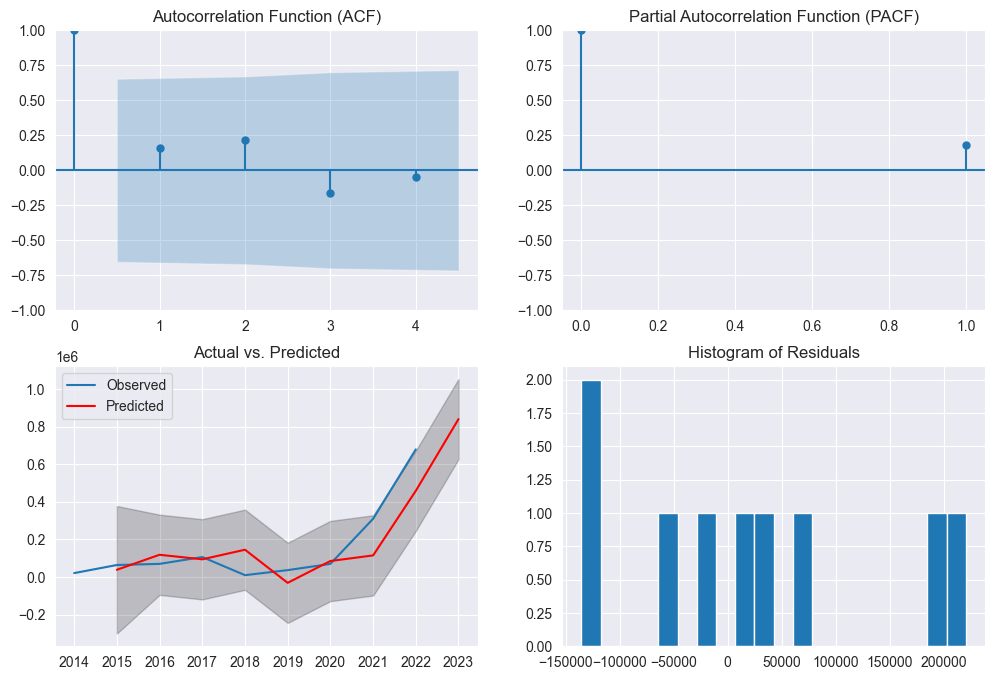

In [99]:
ev_model = my_arima(df=input_electric, name='EV_export')

Due to the limited length of the data, the predictive performance of ARIMA is suboptimal. An attempt is being made to use a power-law function to fit the curve for further analysis.

In [23]:
import numpy as np
import matplotlib.pyplot as plt

years = np.array([14, 15, 16, 17, 18, 19, 20, 21, 22])
data = np.array(export_data['Electric Vehicle'].astype(int))

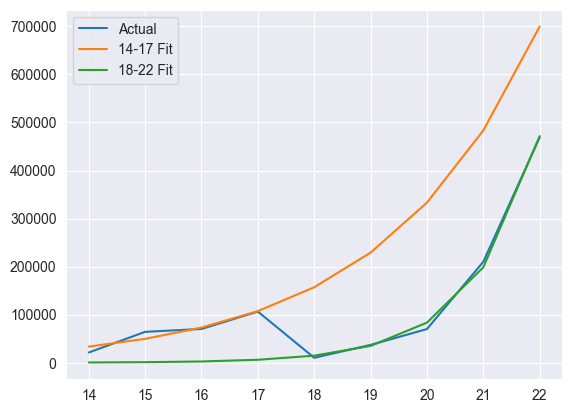

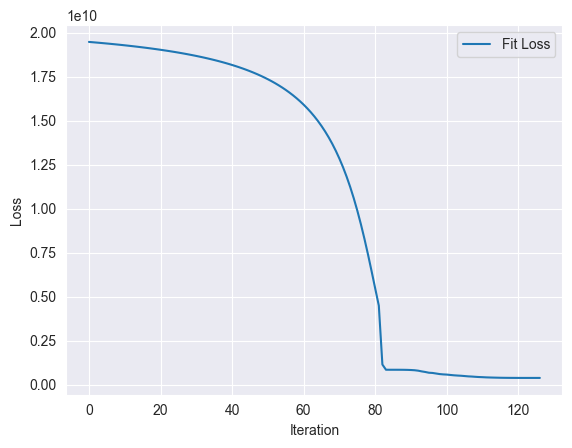

In [24]:
loss_values_14_17 = []
loss_values_18_22 = []
# Define your fit and loss functions
def fit_function(params, x):
    a, b, c = params
    return a * x / np.exp(b * x) ** (-1) + c

def loss_function(params, x, y):
    return np.sum((fit_function(params, x) - y) ** 2)

# Initial parameter values
initial_params_1 = np.ones(3) * 1.3
initial_params_2 = np.ones(3) * 0.024

# Parameter bounds
bounds = [(-np.inf, np.inf), (-np.inf, np.inf), (-np.inf, np.inf)]

# Minimize the loss function and store loss values
result_14_17 = minimize(loss_function, initial_params_1, args=(years[:4], data[:4]), bounds=bounds, callback=lambda x: loss_values_14_17.append(loss_function(x, years[:4], data[:4])))
result_18_22 = minimize(loss_function, initial_params_2, args=(years[4:], data[4:]), bounds=bounds, callback=lambda x: loss_values_18_22.append(loss_function(x, years[4:], data[4:])))

# Generate fit curves
fit_curve_14_17 = fit_function(result_14_17.x, years)
fit_curve_19_22 = fit_function(result_18_22.x, years)

plt.plot(years, data, label='Actual')
plt.plot(years[:9], fit_curve_14_17[:9], label='14-17 Fit')
plt.plot(years, fit_curve_19_22, label='18-22 Fit')
plt.legend()

# Plot loss curves
plt.figure()
plt.plot(loss_values_14_17, label='Fit Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()

plt.show()


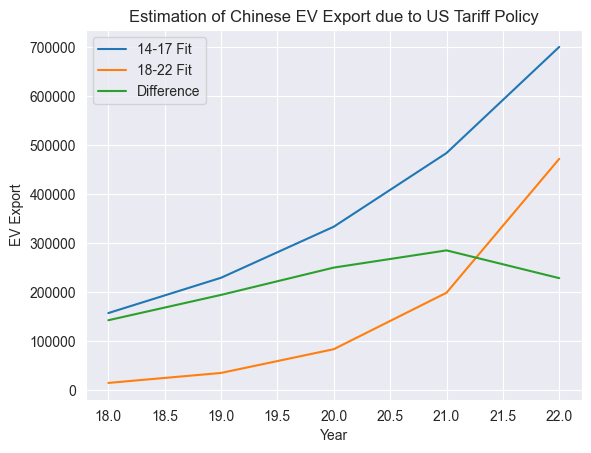

In [25]:
res = fit_curve_14_17[4:]
diff = fit_curve_19_22[4:]
diff = res - diff
plt.plot(years[4:], fit_curve_14_17[4:], label='14-17 Fit')
plt.plot(years[4:], fit_curve_19_22[4:], label='18-22 Fit')
plt.plot(years[4:], diff, label='Difference')
plt.title('Estimation of Chinese EV Export due to US Tariff Policy')
plt.xlabel('Year')
plt.ylabel('EV Export')
plt.legend()

plt.show()